tested on torch example, with convolution layer, can be extracted
Can be indexed. Found that the order of NCHW or NHWC does not matter. Same results are given.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from utils_torch import plot_mnist
from models.Mnist_torch import Mnist_torch


In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
                        transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=1000, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, inputs):
        return self.model(inputs)

In [4]:
model = Net()
model = Mnist_torch(model)

In [5]:
model.load_weights('mnist.pth')

In [6]:
model.get_layer_outputs

{'': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee1c0>,
 'model': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eee50>,
 'model.0': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eef40>,
 'model.1': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee190>,
 'model.2': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eeb20>,
 'model.3': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eed90>,
 'model.4': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eebb0>,
 'model.5': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eebe0>,
 'model.6': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee580>,
 'model.7': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee940>,
 'model.8': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eed60>,
 'model.9': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee670>,
 'model.10': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee610>,
 'model.11': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3eec10>,
 'model.12': <torch.utils.hooks.RemovableHandle at 0x7f8e9f3ee700>}

In [7]:
dataset = torch.tensor([])
dataset_labels = torch.tensor([])
for num, (data, data_set) in enumerate(test_loader):
    if num == 0:
        dataset = torch.tensor(data)
        dataset_labels = torch.tensor(data_set)
    else:
        dataset = torch.cat((dataset, data), 0)
        dataset_labels = torch.cat((dataset_labels, data_set), 0)

/tmp/ipykernel_7668/1528009909.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data)
/tmp/ipykernel_7668/1528009909.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_labels = torch.tensor(data_set)


In [8]:
print(dataset.shape)
print(dataset_labels.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [9]:
dataset_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [10]:
for name, module in model.model.named_modules():
    print(name)


model
model.0
model.1
model.2
model.3
model.4
model.5
model.6
model.7
model.8
model.9
model.10
model.11
model.12


In [11]:
all_layer_names = [layer[0] for layer in model.model.named_modules()]
layer_name = "model.2"
layer_id = all_layer_names.index(layer_name)
print(layer_id)

4


In [12]:
import ctypes
lib_file = "index/build/lib.linux-x86_64-3.8/deepeverst_index.cpython-38-x86_64-linux-gnu.so"
index_lib = ctypes.CDLL(lib_file)

In [13]:
import math
from utils_torch import *

n_images = len(dataset)
n_partitions= 64
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))
print(n_images)
print(type(dataset))

10000
<class 'torch.Tensor'>


In [14]:
print(dataset.shape)
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=None)

torch.Size([10000, 1, 28, 28])


In [15]:
# print(layer_result)
print(layer_result.shape)

torch.Size([10000, 12, 12, 10])


In [16]:
layer_result = layer_result.detach().numpy()
from DeepEverest_torch import *
rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

In [17]:
label_predicted = torch.argmax(model.predict(dataset), axis=1)
print(label_predicted)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [18]:
label_test = dataset_labels
print(label_test)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [19]:
misclassified_mask = label_predicted[:1000] != label_test[:1000]
np.where(misclassified_mask)

(array([ 33,  62,  73, 124, 209, 233, 241, 247, 259, 290, 318, 320, 321,
        445, 448, 449, 479, 495, 511, 530, 543, 551, 571, 582, 591, 659,
        684, 689, 691, 717, 720, 740, 810, 839, 894, 898, 900, 924, 926,
        938, 947, 950, 956, 965]),)

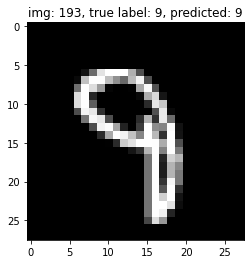

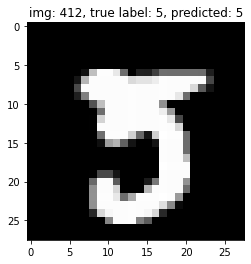

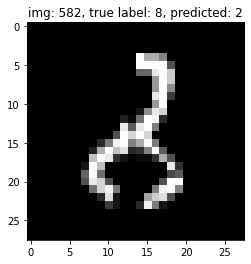

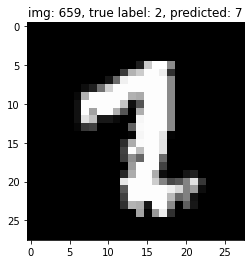

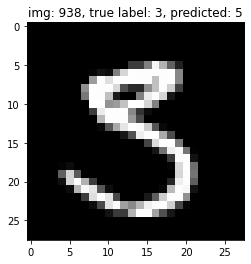

In [20]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1)
    plot_mnist(dataset, label_test, image_id, prediction)

In [21]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = []
    image_samples = []
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    image_samples = torch.stack(image_samples)
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

Set the target input of interest and the number of top activations you want to inspect.  
For example, image 659 is a misclassified example in the dataset.  
Get the top-k activations for this input in this layer and their corresponding neuron IDs.

In [22]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(15.056664, (4, 6, 4)),
 (14.274166, (5, 6, 4)),
 (13.664486, (6, 6, 4)),
 (13.554054, (3, 6, 4)),
 (13.502932, (8, 6, 4)),
 (13.477571, (9, 6, 4)),
 (13.340709, (11, 6, 1)),
 (13.27995, (4, 7, 4)),
 (13.197538, (5, 3, 1)),
 (13.188957, (3, 7, 4)),
 (13.090613, (10, 6, 1)),
 (12.774042, (5, 4, 1)),
 (12.733601, (2, 6, 4)),
 (12.522223, (7, 6, 4)),
 (12.089676, (5, 7, 4)),
 (11.97962, (11, 7, 1)),
 (11.603155, (8, 5, 4)),
 (11.496715, (2, 7, 4)),
 (11.474282, (3, 7, 0)),
 (11.457584, (4, 4, 1))]

Construct the group of neurons that you are interested in, e.g., the top-3 maximally activated neurons.

In [23]:
from NeuronGroup import *
image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

In [24]:
dataset.shape

torch.Size([10000, 1, 28, 28])

Query for the k-nearest neighbors in the dataset using the activations of this group of neurons  
based on the proximity in the latent space defined by this group of neurons.  
answer_query_with_guarantee() runs the Neural Threshold Algorithm.

In [25]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 0.10146905481815338, max in answer: 1.40303635597229, images run: 67
threshold: 0.20118562877178192, max in answer: 1.1438370943069458, images run: 132
threshold: 0.2788737714290619, max in answer: 0.9198803901672363, images run: 196
threshold: 0.42958271503448486, max in answer: 0.7807649374008179, images run: 260
threshold: 0.5854843854904175, max in answer: 0.7519282102584839, images run: 325
threshold: 0.7778107523918152, max in answer: 0.7440550923347473, images run: 389
======================= NTA exited =======================


([(-0.7440551, 2915),
  (-0.7409354, 6074),
  (-0.6970588, 8109),
  (-0.6478751, 7822),
  (-0.6055464, 3611),
  (-0.58405477, 6118),
  (-0.5718313, 4011),
  (-0.53731173, 8100),
  (-0.52412087, 4097),
  (-0.5215469, 4861),
  (-0.46935377, 6988),
  (-0.44762346, 6096),
  (-0.4275496, 8048),
  (-0.4268946, 7783),
  (-0.42228025, 1909),
  (-0.41333342, 3229),
  (-0.3712188, 1480),
  (-0.23766346, 8679),
  (-0.113409005, 8112),
  (0.0, 659)],
 'termination: images run: 389')

Visualize the top-k results.

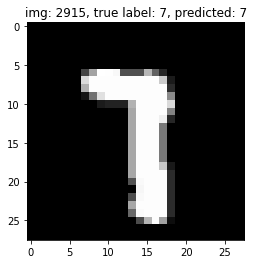

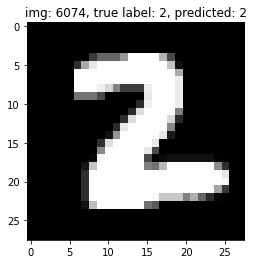

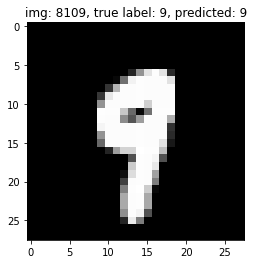

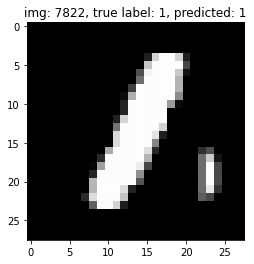

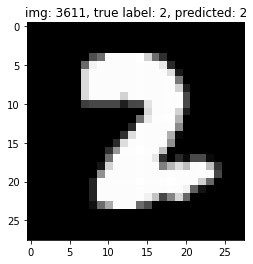

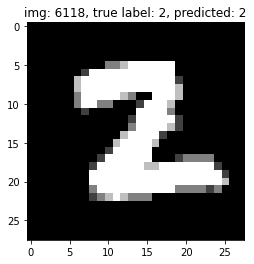

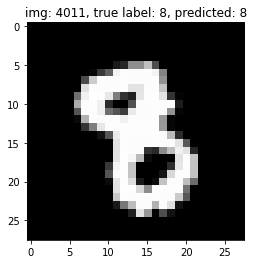

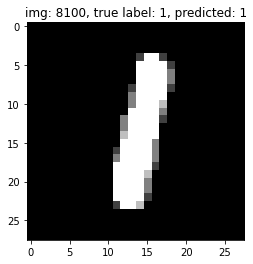

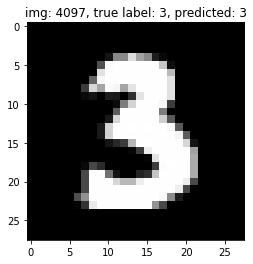

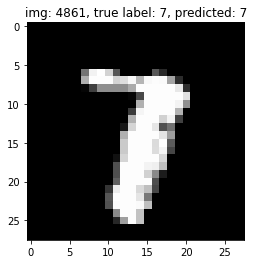

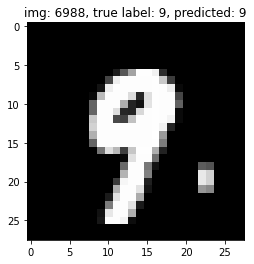

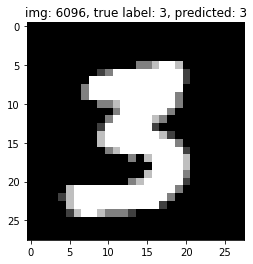

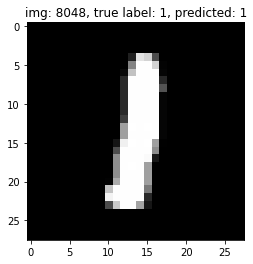

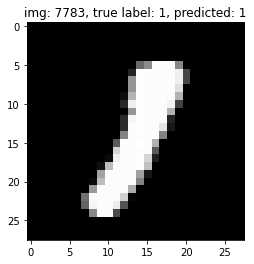

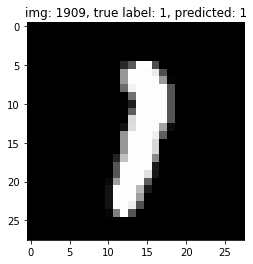

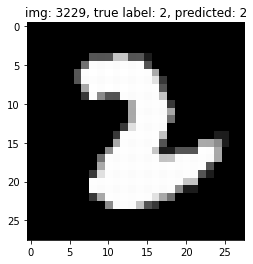

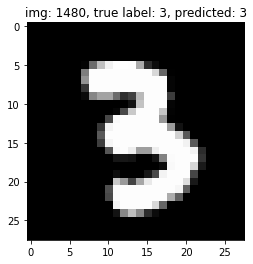

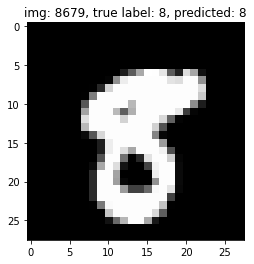

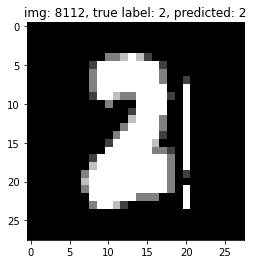

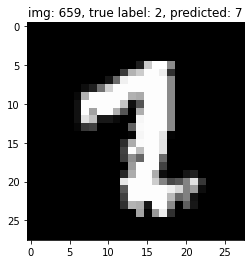

In [26]:
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [27]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

In [28]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(dataset.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

print(two_as_two, seven_as_seven, two_as_seven, seven_as_two)

1 0 321 810


In [29]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

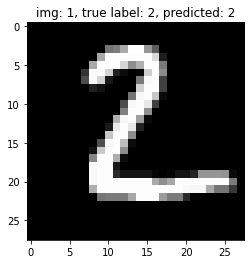

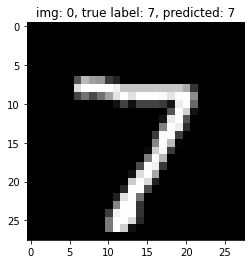

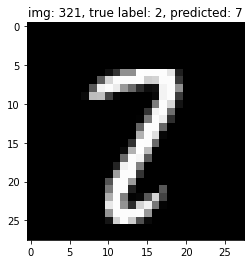

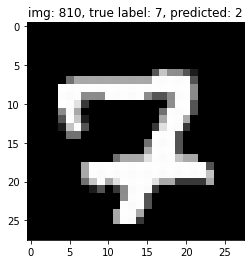

In [30]:
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [31]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)
topk_activations

[[(15.404506, (10, 6, 1)),
  (14.740844, (10, 9, 1)),
  (14.725686, (10, 5, 1)),
  (14.658377, (10, 4, 1)),
  (14.074226, (10, 7, 1)),
  (14.018891, (10, 10, 1)),
  (13.745972, (10, 3, 1)),
  (13.607746, (2, 5, 1)),
  (13.291188, (10, 8, 1)),
  (12.143644, (2, 4, 1)),
  (11.776539, (2, 6, 4)),
  (11.771938, (6, 4, 4)),
  (11.722886, (8, 3, 4)),
  (11.716561, (1, 5, 1)),
  (11.585614, (3, 6, 4)),
  (11.531162, (7, 3, 4)),
  (11.222839, (5, 4, 4)),
  (11.1286335, (4, 5, 4)),
  (11.101066, (10, 11, 1)),
  (11.002071, (5, 5, 4))],
 [(14.003622, (4, 4, 1)),
  (13.753479, (4, 5, 1)),
  (13.233683, (4, 3, 1)),
  (13.210785, (4, 6, 1)),
  (12.756104, (4, 7, 1)),
  (10.772835, (11, 4, 4)),
  (10.763884, (10, 5, 4)),
  (10.652996, (4, 8, 4)),
  (10.51455, (3, 3, 1)),
  (10.362712, (4, 2, 1)),
  (10.331228, (3, 2, 1)),
  (9.836474, (9, 5, 4)),
  (9.813205, (5, 8, 4)),
  (9.546487, (10, 4, 4)),
  (9.501915, (8, 6, 4)),
  (9.265276, (11, 5, 4)),
  (9.024993, (7, 7, 4)),
  (8.871638, (6, 7, 4)),
  (

In [32]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
print(neuron_cnt)

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

{(10, 6, 1): 1, (10, 9, 1): 1, (10, 5, 1): 1, (10, 4, 1): 1, (10, 7, 1): 1, (10, 10, 1): 1, (10, 3, 1): 1, (2, 5, 1): 1, (10, 8, 1): 1, (2, 4, 1): 1, (2, 6, 4): 1, (6, 4, 4): 1, (8, 3, 4): 1, (1, 5, 1): 1, (3, 6, 4): 1, (7, 3, 4): 1, (5, 4, 4): 1, (4, 5, 4): 1, (10, 11, 1): 1, (5, 5, 4): 1, (4, 4, 1): 3, (4, 5, 1): 2, (4, 3, 1): 3, (4, 6, 1): 2, (4, 7, 1): 1, (11, 4, 4): 1, (10, 5, 4): 2, (4, 8, 4): 2, (3, 3, 1): 1, (4, 2, 1): 1, (3, 2, 1): 1, (9, 5, 4): 2, (5, 8, 4): 1, (10, 4, 4): 2, (8, 6, 4): 2, (11, 5, 4): 1, (7, 7, 4): 2, (6, 7, 4): 2, (4, 8, 0): 1, (9, 6, 4): 2, (3, 6, 1): 1, (3, 4, 1): 1, (3, 5, 1): 1, (3, 7, 1): 2, (3, 7, 4): 1, (11, 4, 1): 1, (6, 6, 4): 1, (8, 5, 4): 2, (11, 5, 1): 1, (5, 6, 4): 1, (4, 7, 4): 1, (7, 5, 4): 1, (9, 4, 4): 1, (3, 7, 0): 1, (8, 4, 4): 1, (5, 7, 4): 2, (10, 5, 0): 1, (9, 9, 1): 1, (9, 4, 1): 1, (9, 8, 1): 1, (9, 3, 1): 1, (7, 6, 4): 1, (8, 7, 4): 1}


[((4, 4, 1), 3),
 ((4, 3, 1), 3),
 ((4, 5, 1), 2),
 ((4, 6, 1), 2),
 ((10, 5, 4), 2),
 ((4, 8, 4), 2),
 ((9, 5, 4), 2),
 ((10, 4, 4), 2),
 ((8, 6, 4), 2),
 ((7, 7, 4), 2),
 ((6, 7, 4), 2),
 ((9, 6, 4), 2),
 ((3, 7, 1), 2),
 ((8, 5, 4), 2),
 ((5, 7, 4), 2),
 ((10, 6, 1), 1),
 ((10, 9, 1), 1),
 ((10, 5, 1), 1),
 ((10, 4, 1), 1),
 ((10, 7, 1), 1),
 ((10, 10, 1), 1),
 ((10, 3, 1), 1),
 ((2, 5, 1), 1),
 ((10, 8, 1), 1),
 ((2, 4, 1), 1),
 ((2, 6, 4), 1),
 ((6, 4, 4), 1),
 ((8, 3, 4), 1),
 ((1, 5, 1), 1),
 ((3, 6, 4), 1),
 ((7, 3, 4), 1),
 ((5, 4, 4), 1),
 ((4, 5, 4), 1),
 ((10, 11, 1), 1),
 ((5, 5, 4), 1),
 ((4, 7, 1), 1),
 ((11, 4, 4), 1),
 ((3, 3, 1), 1),
 ((4, 2, 1), 1),
 ((3, 2, 1), 1),
 ((5, 8, 4), 1),
 ((11, 5, 4), 1),
 ((4, 8, 0), 1),
 ((3, 6, 1), 1),
 ((3, 4, 1), 1),
 ((3, 5, 1), 1),
 ((3, 7, 4), 1),
 ((11, 4, 1), 1),
 ((6, 6, 4), 1),
 ((11, 5, 1), 1),
 ((5, 6, 4), 1),
 ((4, 7, 4), 1),
 ((7, 5, 4), 1),
 ((9, 4, 4), 1),
 ((3, 7, 0), 1),
 ((8, 4, 4), 1),
 ((10, 5, 0), 1),
 ((9, 9, 1), 

image 810, size of neuron group 3
threshold: 0.4012274742126465, max in answer: 1.244203805923462, images run: 67
threshold: 0.7033581137657166, max in answer: 1.01547372341156, images run: 131
threshold: 0.9670814871788025, max in answer: 0.9958177804946899, images run: 195
threshold: 1.2530744075775146, max in answer: 0.9958177804946899, images run: 260
======================= NTA exited =======================


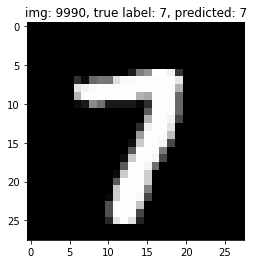

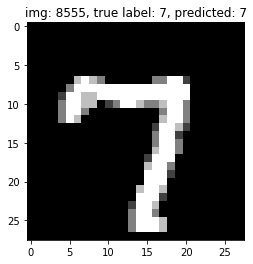

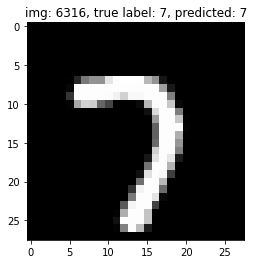

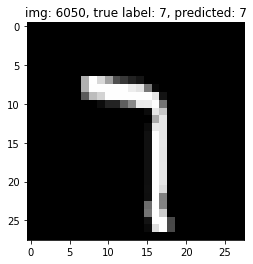

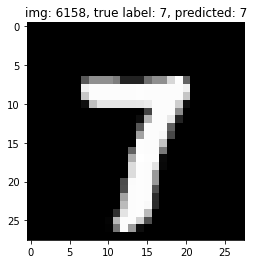

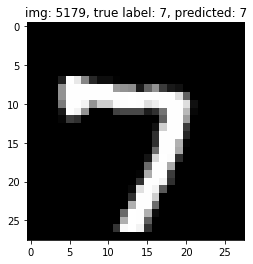

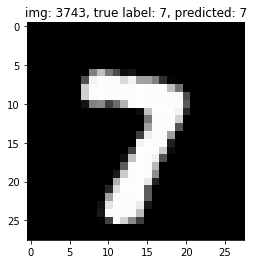

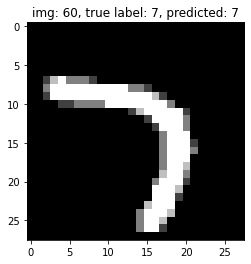

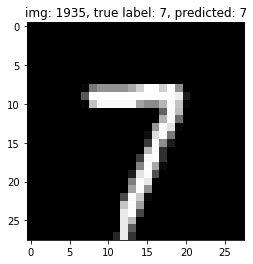

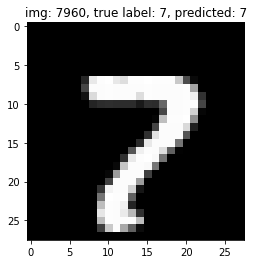

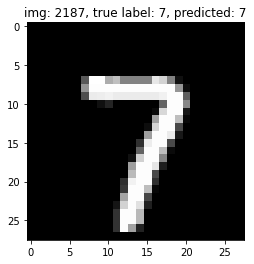

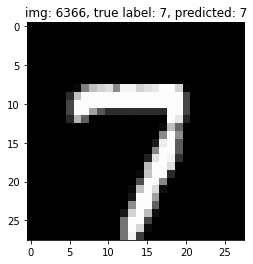

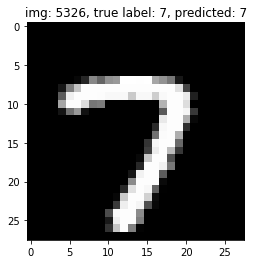

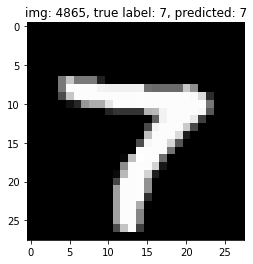

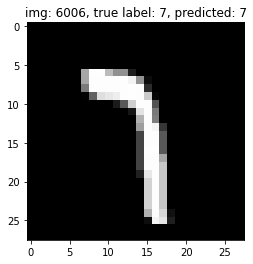

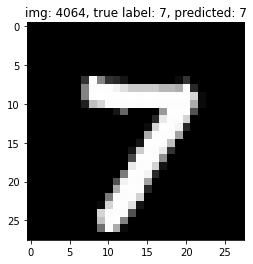

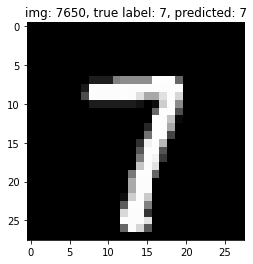

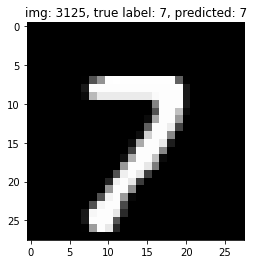

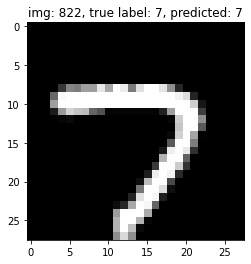

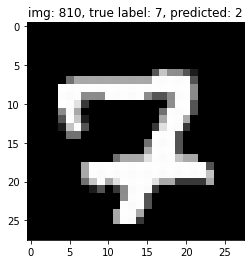

In [33]:
image_sample_id = seven_as_two
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:3])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

image 810, size of neuron group 3
threshold: 0.03818821907043457, max in answer: 0.1384831666946411, images run: 427
threshold: 0.20468735694885254, max in answer: 0.07035708427429199, images run: 851
======================= NTA exited =======================


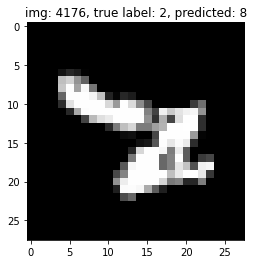

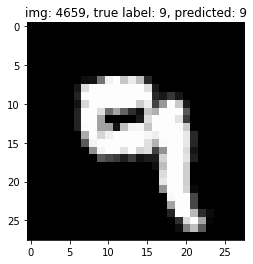

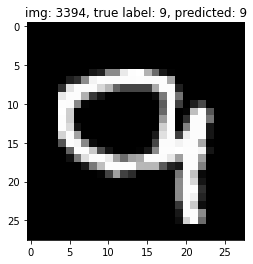

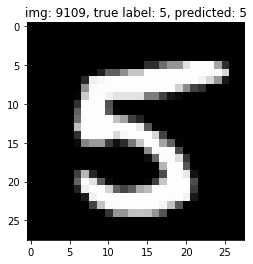

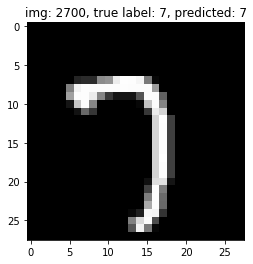

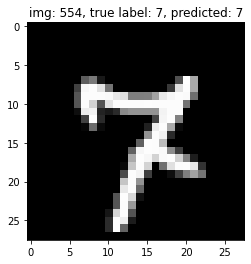

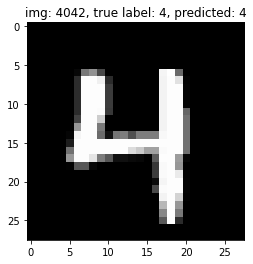

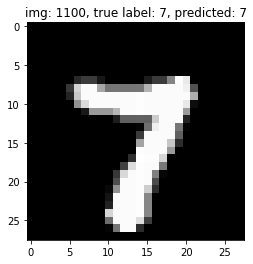

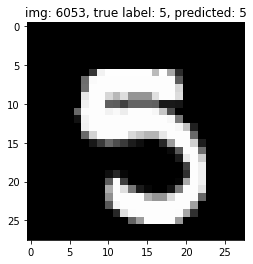

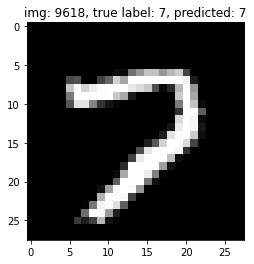

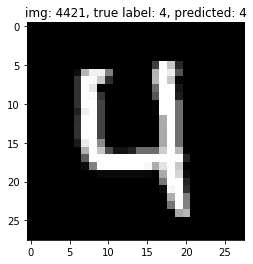

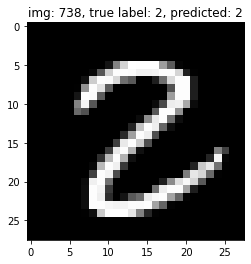

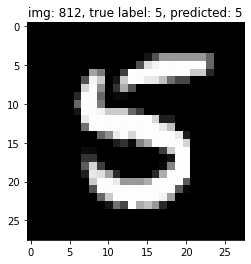

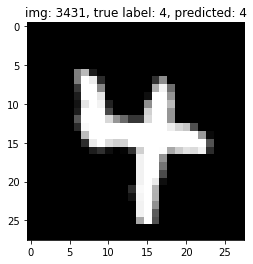

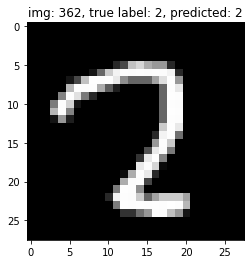

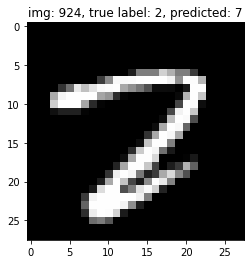

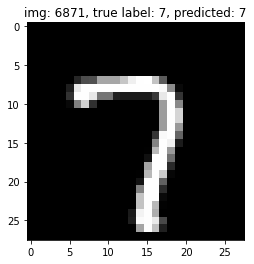

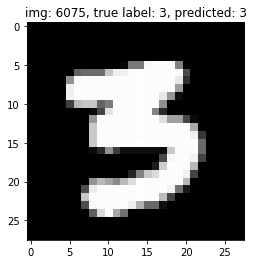

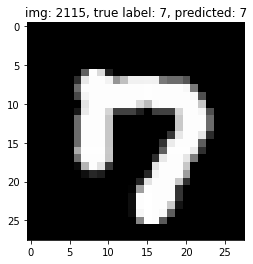

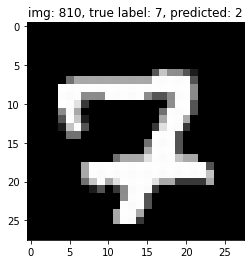

In [35]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=[(0, 2, 5), (2, 2, 8), (4, 1, 2)])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [ ]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 3, 7): 2,
 (4, 8, 5): 2,
 (1, 4, 3): 2,
 (4, 5, 7): 2,
 (1, 4, 4): 2,
 (1, 3, 6): 1,
 (1, 3, 4): 1,
 (1, 3, 5): 1,
 (4, 3, 7): 1,
 (1, 11, 4): 1,
 (4, 6, 6): 1,
 (1, 11, 5): 1,
 (4, 5, 6): 1,
 (4, 4, 7): 1,
 (4, 7, 5): 1,
 (4, 10, 4): 1,
 (4, 9, 4): 1,
 (0, 3, 7): 1,
 (4, 8, 4): 1,
 (0, 10, 5): 1,
 (1, 4, 5): 1,
 (1, 9, 9): 1,
 (1, 9, 4): 1,
 (1, 9, 8): 1,
 (4, 7, 7): 1,
 (1, 9, 3): 1,
 (1, 4, 6): 1,
 (4, 10, 5): 1,
 (4, 4, 8): 1,
 (4, 7, 6): 1,
 (4, 6, 7): 1,
 (4, 8, 7): 1,
 (4, 8, 6): 1,
 (4, 9, 5): 1,
 (4, 9, 6): 1}